# A Level-2 Sea Ice Drift (SID) algorithm for CIMR

This notebook implements a prototype for a Level-2 SIED algorithm for the CIMR mission.

We refer to the corresponding [ATBD](https://cimr-algos.github.io/SeaIceDrift_ATBD/intro.html) and especially the [Baseline Algorithm Definition](https://cimr-algos.github.io/SeaIceDrift_ATBD/baseline_algorithm_definition.html#baseline-algorithm-definition).

In particular, the figure below illustrates the overall concept of the processing:
<img src="https://cimr-algos.github.io/SeaIceDrift_ATBD/_images/CIMR_L2_Sea_Ice_Drift_Flow_Diagram.png" width="100%"/>

## Settings

Imports and general settings

In [1]:
%load_ext cython

In [2]:
# Paths

# Getting the path of the notebook (NOTE: not totally safe)
# The paths assume that there is an umbrella CIMR directory (of any name) containing SeaIceDrift_ATBD_v2/ ,
# the CIMR Tools/ directory, and a directory data/L1B/ containing the L1B data, and data/conc/ containing
# a concentration file.
# Additionally, this code expects that the CIMR L2 Sea Ice Drift algorithm notebook has been run, to create
# the drift file
import os
cpath = os.path.join(os.getcwd(), '../..')
algpath = os.path.join(cpath, 'SeaIceDrift_ATBD_v2/algorithm/src_sied')
toolpath = os.path.join(cpath, 'Tools')
l1bpath = os.path.join(cpath, 'data/L1B')
concpath = os.path.join(cpath, 'data/conc')
driftpath = os.path.join(cpath, 'data/icedrift')
logpath = os.path.join(cpath, 'data/logs')
figpath = os.path.join(cpath, 'data/figs')

In [3]:
# Imports

from importlib import reload
import sys
import shutil
import math
import numpy as np
import numpy.ma as ma
import xarray as xr
from netCDF4 import Dataset
from matplotlib import pylab as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.cm as cm
import cmocean
import cartopy
import cartopy.crs as ccrs
from pyresample import parse_area_file
from datetime import datetime, timedelta

# Local modules contain software code that implement the SIED algorithm
if algpath not in sys.path:
    sys.path.insert(0, algpath)

In [4]:
# Plot settings

import matplotlib
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'axes.labelsize': 12})

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
cmap = cm.viridis
cmapland = matplotlib.colors.ListedColormap(['none', 'grey'])

gridtype = 'ease'
gridin = '{}-ease2-050'
gridout = '{}-ease2-250'
# Some region parameters hard-coded to show only the relevant region
# Overall shape of input grid (4320, 4320)
sl = (1050, 1400, 1050, 1400)
slo = (200, 290, 200, 290)

# EASE plotting region
lon_min = -15
lon_max = 95
lat_min = 74
lat_max = 90

# Settings for gridlines
lon_step = 10
lat_step = 5

plotfigs=True

## Parametrize the run

User-set parameters for the running of the whole notebook

In [5]:
hemi = 'nh'

test_card = "radiometric"

dt = datetime.strptime('20230420T103323', '%Y%m%dT%H%M%S')
pdate = datetime.strptime('20280110', '%Y%m%d')
qdate = pdate + timedelta(days=1)

griddeffile = os.path.join(algpath, 'grids_py.def')

ncfile = os.path.join(driftpath, 'cimr_devalgo_l2_sid_{}_{}.nc'.format(gridout.format(hemi), test_card))

pixshx = 3
pixshy = 4

plotfigs = False

## Simple Validation

A simple validation based on the shift used to create the second file needed to calculate drift. In the test example, a constant shift of +3 pixels in the x-direction and +4 pixels in the y-direction is chosen.


In [6]:
def crs_create(gridtype, hemi):

    # Define grid based on region
    if gridtype == 'polstere':
        if hemi == 'nh':
            plot_proj4_params = {'proj': 'stere',
                                 'lat_0': 90.,
                                 'lat_ts' : 70.,
                                 'lon_0': -45.0,
                                 'a': 6378273,
                                 'b': 6356889.44891}
            plot_globe = ccrs.Globe(semimajor_axis=plot_proj4_params['a'],
                                    semiminor_axis=plot_proj4_params['b'])
            plot_crs = ccrs.NorthPolarStereo(
                central_longitude=plot_proj4_params['lon_0'], globe=plot_globe)
        else:
            plot_proj4_params = {'proj': 'stere',
                                 'lat_0': -90.,
                                 'lat_ts' : -70.,
                                 'lon_0': 0.,
                                 'a': 6378273,
                                 'b': 6356889.44891}
            plot_globe = ccrs.Globe(semimajor_axis=plot_proj4_params['a'],
                                    semiminor_axis=plot_proj4_params['b'])
            plot_crs = ccrs.SouthPolarStereo(
                central_longitude=plot_proj4_params['lon_0'], globe=plot_globe)
    elif gridtype == 'ease':
        if hemi == 'nh':
            plot_crs = ccrs.LambertAzimuthalEqualArea(central_longitude=0,
                                                      central_latitude=90,
                                                      false_easting=0,
                                                      false_northing=0)
        else:
            plot_crs = ccrs.LambertAzimuthalEqualArea(central_longitude=0,
                                                      central_latitude=-90,
                                                      false_easting=0,
                                                      false_northing=0)
    else:
        raise ValueError("Unrecognised region {}".format(region))

    return(plot_crs)

In [7]:
# Reading NetCDF file

def nc_read(ncfile, var, skip=None, procfmt=False):

    ncdata = {}

    if isinstance(var, list):
        v = var[0]
    else:
        v = var

    # Reading from the NetCDF file
    with Dataset(ncfile, 'r') as dataset:

        try:
            ncdata['fv'] = dataset.variables[v].__dict__['_FillValue']
        except:
            pass

        if isinstance(var, list):
            varlist = var
        else:
            varlist = [var]
        for item in varlist:
            vardata = dataset[item][:]
            if len(vardata.shape) == 3:
                if skip:
                    vardata = vardata[0, ::skip, ::skip]
                else:
                    vardata = vardata[0, :, :]
            else:
                if skip:
                    vardata = vardata[::skip, ::skip]
                else:
                    vardata = vardata[:, :]

            # This is for reducing flags to the lowest integers
            if var in ['statusflag', 'status_flag', 'flag']:
                vardata = np.asarray(vardata, float) + 100
                uniques = np.unique(vardata)
                uniques = uniques[np.logical_not(np.isnan(uniques))]
                for newval, origval in enumerate(uniques):
                    vardata[vardata == origval] = newval
                ncdata['sf_labs'] = [str(int(u - 100)) for u in uniques]

            # NOTE: Be very careful with the fill value here. Trying to
            # use ncdata['fv'] as the fill_value for a status array such
            # as 'flag' means that flag values of 0 (i.e. nominal) are
            # masked out
            if 'fv' in ncdata.keys() and item not in ['statusflag',
                                                      'status_flag', 'flag']:
                ncdata[item] = ma.array(vardata, fill_value=ncdata['fv'])
            else:
                ncdata[item] = ma.array(vardata)

            if var in ['statusflag', 'status_flag', 'flag']:
                ncdata[item].mask = None
            else:
                ncdata[item].mask = ncdata[item].data == ncdata[item].fill_value

        if skip:
            ncdata['lon'] = dataset.variables['lon'][::skip, ::skip]
            ncdata['lat'] = dataset.variables['lat'][::skip, ::skip]
        else:
            ncdata['lon'] = dataset.variables['lon'][:]
            ncdata['lat'] = dataset.variables['lat'][:]

        # Try fetching time info
        try:
            try:
                d0 = datetime.strptime(dataset.start_date,'%Y-%m-%d %H:%M:%S')
                d1 = datetime.strptime(dataset.stop_date,'%Y-%m-%d %H:%M:%S')
            except:
                try:
                    d0 = datetime.strptime(dataset.start_date_and_time,
                                           '%Y-%m-%dT%H:%M:%SZ')
                    d1 = datetime.strptime(dataset.end_date_and_time,
                                           '%Y-%m-%dT%H:%M:%SZ')
                except:
                    d0 = datetime.strptime(dataset.time_coverage_start,
                                           '%Y-%m-%dT%H:%M:%SZ')
                    d1 = datetime.strptime(dataset.time_coverage_end,
                                           '%Y-%m-%dT%H:%M:%SZ')
            d0_00 = datetime.combine(d0.date(),time(0))
            d1_00 = datetime.combine(d1.date(),time(0))
            ncdata['sdate'] = d0_00
            ncdata['edate'] = d1_00
            ncdata['tspan_hours'] = (d1_00 - d0_00).total_seconds() / (60.*60.)
        except:
            pass

        ncdata['time'] = dataset.variables['time'][0]

    return ncdata


In [8]:
# Reading in the data

varlist = ['driftX', 'driftY', 'status_flag']
iddata = nc_read(ncfile, varlist, skip=None, procfmt=True)

Here the ice drift in the x-direction and the y-direction is plotted, and the status flags.

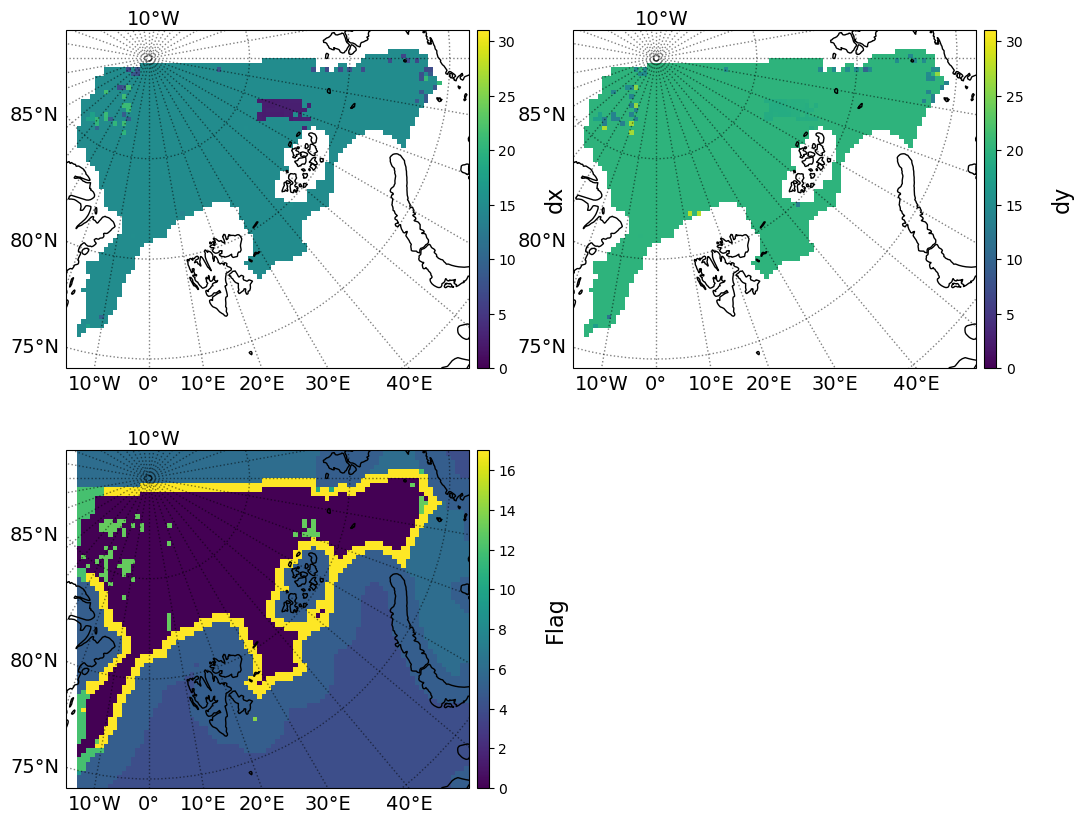

FLAG VALUES 
Unprocessed pixel                              -1
Nominal                                        0
Outside image border                           1
Close to image border                          2
Pixel center over land                         3
No ice                                         4
Close to coast or edge                         5
Close to missing pixel                         6
Close to unprocessed pixel                     7
Icedrift optimisation failed                   8
Icedrift failed                                9
Icedrift with low correlation                  10
Icedrift calculation took too long             11
Icedrift calculation refused by neighbours     12
Icedrift calculation corrected by neighbours   13
Icedrift no average                            14
Icedrift masked due to summer season           15
Icedrift multi-oi interpolation                16
Icedrift calcuated with smaller pattern        17
Icedrift masked due to NWP                     

In [9]:
# Plotting the ice drift
# Modified from the SeaSurfaceTemperature_ATBD_v2, by Emy Alerskans

# Drift data
xydata = {'dx': iddata['driftX'], 'dy': iddata['driftY']}
flag = iddata['status_flag']
limminxy = np.nanmin([np.nanmin(a) for a in xydata.values()])
limminxy = limminxy - 0.1 * abs(limminxy)
limmaxxy = np.nanmax([np.nanmax(a) for a in xydata.values()])
limmaxxy = limmaxxy + 0.1 * abs(limmaxxy)
limminflag = np.nanmin(flag)
limmaxflag = np.nanmax(flag)

# Output lat/lons
og = gridout.format(hemi)
out_area_def = parse_area_file(griddeffile, og)[0]
olons, olats = out_area_def.get_lonlats()

# Coordinate reference systems
plot_crs = crs_create(gridtype, hemi)
pc = ccrs.PlateCarree()

# Plotting drift
fig = plt.figure(figsize=[12, 10])
for i, var in enumerate(list(xydata.keys())):
    ax = fig.add_subplot(2, 2, i+1, projection=plot_crs)
    im = ax.pcolormesh(olons[slo[0]:slo[1], slo[2]:slo[3]], olats[slo[0]:slo[1], slo[2]:slo[3]], 
                       xydata[var][:][slo[0]:slo[1], slo[2]:slo[3]], transform=pc,
                       cmap=cmap, vmin=0, vmax=math.ceil(limmaxxy))
    ax.coastlines()
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle=':')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, lon_step))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, lat_step))
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
        
    # Colourbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad="2%", axes_class=plt.Axes)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label(label=var, fontsize=16, labelpad=20.0)
    cb.ax.set_ylim(0, math.ceil(limmaxxy))
    

# Status flags
ax = fig.add_subplot(2, 2, 3, projection=plot_crs)
im = ax.pcolormesh(olons[slo[0]:slo[1], slo[2]:slo[3]], olats[slo[0]:slo[1], slo[2]:slo[3]], 
                    flag[:][slo[0]:slo[1], slo[2]:slo[3]], transform=pc,
                    cmap=cmap, vmin=limminflag, vmax=limmaxflag)
ax.coastlines()
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, lon_step))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, lat_step))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
        
# Colourbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad="2%", axes_class=plt.Axes)
cb = fig.colorbar(im, cax=cax)
cb.set_label(label="Flag", fontsize=16, labelpad=20.0)
cb.ax.set_ylim(limminflag, limmaxflag)
        
if plotfigs:
    plt.savefig(os.path.join(figpath, 'dxdy.png'))
plt.show()

print("\
FLAG VALUES \n\
Unprocessed pixel                              -1\n\
Nominal                                        0\n\
Outside image border                           1\n\
Close to image border                          2\n\
Pixel center over land                         3\n\
No ice                                         4\n\
Close to coast or edge                         5\n\
Close to missing pixel                         6\n\
Close to unprocessed pixel                     7\n\
Icedrift optimisation failed                   8\n\
Icedrift failed                                9\n\
Icedrift with low correlation                  10\n\
Icedrift calculation took too long             11\n\
Icedrift calculation refused by neighbours     12\n\
Icedrift calculation corrected by neighbours   13\n\
Icedrift no average                            14\n\
Icedrift masked due to summer season           15\n\
Icedrift multi-oi interpolation                16\n\
Icedrift calcuated with smaller pattern        17\n\
Icedrift masked due to NWP                     18\n\
")

The example shift between the files is +3 pixels in the x-direction and +4 pixels in the y-direction. On the 5km grid, this translates to 15 km in x and 20 km in y. With regards to these shifts, the residuals in the x-direction and the y-direction are plotted.

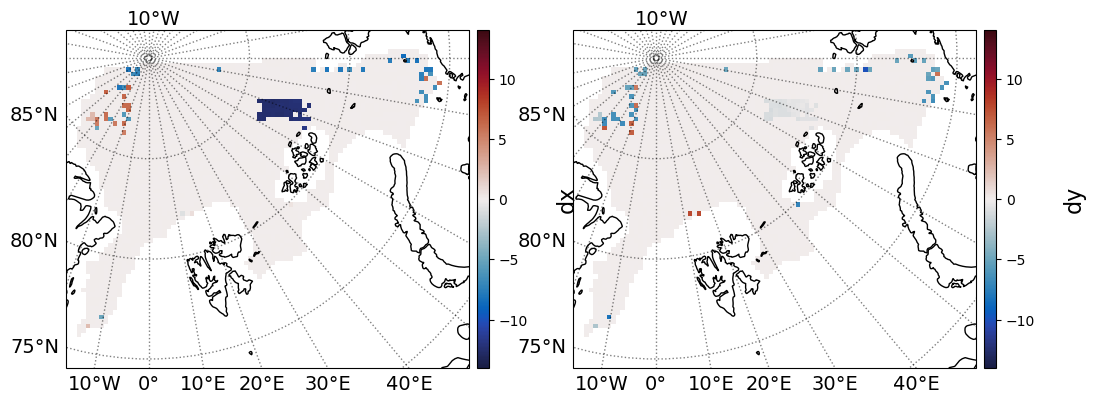

In [10]:
# Plotting the residuals
# Modified from the SeaSurfaceTemperature_ATBD_v2, by Emy Alerskans

pixsize = 5.0
expectedx = pixshx * pixsize
expectedy = pixshy * pixsize
testx = np.full(iddata['driftX'].shape, expectedx)
testy = np.full(iddata['driftX'].shape, expectedy)

testdata = {'dx': testx, 'dy': testy}
resx = iddata['driftX'] - testx
resy = iddata['driftY'] - testy
resdata = {'dx': resx, 'dy': resy}

limminres = np.nanmin([np.nanmin(a) for a in resdata.values()])
limminres = limminres - 0.1 * abs(limminres)
limmaxres = np.nanmax([np.nanmax(a) for a in resdata.values()])
limmaxres = limmaxres + 0.1 * abs(limmaxres)
lim = max([abs(limminres), limmaxres])

fig = plt.figure(figsize=[12, 5])
for i, var in enumerate(list(resdata.keys())):
    ax = fig.add_subplot(1, 2, i+1, projection=plot_crs)
    im = ax.pcolormesh(olons[slo[0]:slo[1], slo[2]:slo[3]], olats[slo[0]:slo[1], slo[2]:slo[3]], 
                       resdata[var][:][slo[0]:slo[1], slo[2]:slo[3]], transform=pc,
                       cmap=cmocean.cm.balance, vmin=-lim, vmax=lim)
    ax.coastlines()
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle=':')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, lon_step))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, lat_step))
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
        
    # Colourbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad="2%", axes_class=plt.Axes)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label(label=var, fontsize=16, labelpad=20.0)
    cb.ax.set_ylim(-lim, lim)
        
if plotfigs:
    plt.savefig(os.path.join(figpath, 'resdxdy.png'))
plt.show()


Histograms of the residuals are plotted.

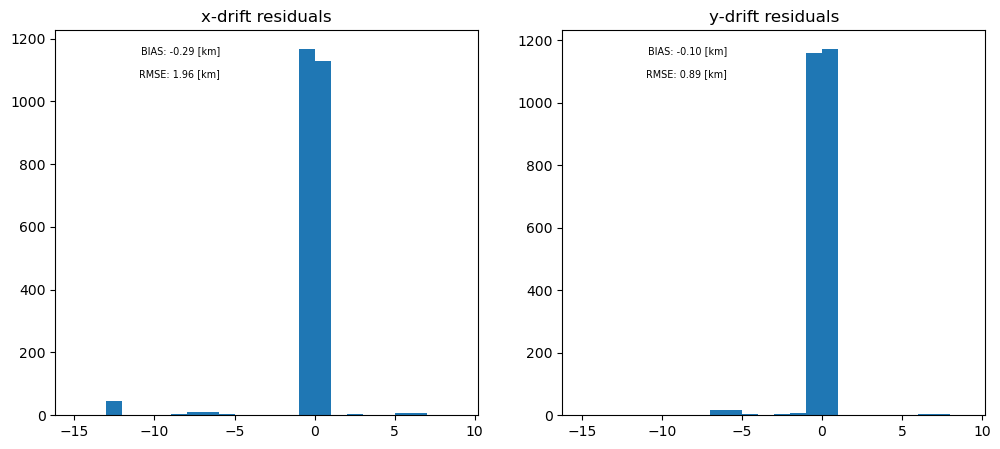

In [11]:
# Plotting a histogram

minbin = math.floor(limminres)
maxbin = math.ceil(limmaxres) + 1
hbins = list(range(minbin, maxbin, 1))
#step = 0.5
#hbins = [(step * x) + minbin for x in range((int(abs(maxbin - minbin) / step)))]

import matplotlib.transforms as transforms

fig = plt.figure(figsize=(12,5))
ax = {}
c = {}
for i, var in enumerate(list(resdata.keys())):
    ax[i] = fig.add_subplot(1,len(resdata),i+1)    
    ax[i].hist(resdata[var][:].flatten(), bins=hbins)
    ax[i].set_title('{}-drift residuals'.format(var[1:2]), fontsize=12)

    ax[i].text(0.39,0.96, 'BIAS: {:.2f} [km]'.format(np.nanmean(resdata[var])),
        transform=ax[i].transAxes, ha='right', va='top', fontsize='xx-small')
    ax[i].text(0.39,0.90, 'RMSE: {:.2f} [km]'.format(np.nanstd(resdata[var])),
        transform=ax[i].transAxes, ha='right', va='top', fontsize='xx-small')

if plotfigs:
    plt.savefig(os.path.join(figpath, 'hist_res.png'))
plt.show()

The RMSE for this artifical data is low, ~2 km, and the bias is also reasonably low, -0.3 km.